 # CRI Maximisation

 This notebook will carry n primary optimisation with intensities matched to the target intensity (n dim opt).
 I will explore, different cost functions and different optimisation strategies.

 The purpose was to be more mechanical with the optimisation process and not inject too much knowledge into it.
 IE trying to fit the shape of the D65 spectrum as accurately as possible.

### Imports

In [1]:
import warnings
import colour
from scipy.stats import norm
from scipy import optimize
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

from bokeh.io import show, output_notebook, export_png
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Whisker
output_notebook()

Loading BokehJS ...

### Config

In [15]:
# Config parameters
figPath = "_plots"  # directory to save figures
touchDisk = False  # set this to true if you want to save figures to the disk. By default the script will not affect the file system on the host system
fullOptHistory = True #Set this to plot the full history of the cost functions during optimisation

# Change this to change the cost function
optimiseSpect_by = "nEmissionCostFn_criAndxyDiff_2"

warnings.simplefilter("ignore")
if touchDisk and not os.path.exists(figPath):
    os.makedirs(figPath)

### Utility functions

In [16]:
def generateMultiPrimarySpectrum(meanLambdas, fwhm_narrow=20):

    var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))
    test_spectrum = np.zeros_like(target_wide_emission_wavelengths)

    for _, primaryLambda in enumerate(meanLambdas):
        primary_spectrum = norm.pdf(
            target_wide_emission_wavelengths, loc=primaryLambda, scale=var)
        primary_spectrum = target_wide_emission_SD[primaryLambda] * \
            primary_spectrum/np.max(primary_spectrum)
        test_spectrum += primary_spectrum

    test_spectrum_sd = colour.SpectralDistribution(
        test_spectrum, target_wide_emission_wavelengths)

    return test_spectrum_sd


def plotSpectChrCRI(test_spectrum_sd):
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

    ax1.plot(target_wide_emission_wavelengths, test_spectrum_sd.values)
    ax1.plot(target_wide_emission_wavelengths,
             target_wide_emission_values, '--')
    ax1.set_ylabel("radiance w/m^2/sr")
    ax1.set_xlabel("wavelength (nm)")
    ax1.set_title(f'xy = [{test_spectrum_tristim_xy[0]:.3f},{test_spectrum_tristim_xy[1]:.3f}],d00 = {colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))):.3f}, CRI = {colour.colour_rendering_index(test_spectrum_sd):.3f}')
    colour.plotting.plot_chromaticity_diagram_CIE1931(
        standalone=False, cmfs='CIE 1931 2 Degree Standard Observer', axes=ax2)
    ax2.set_title("CIE 2' std. obs.")
    ax2.scatter(*test_spectrum_tristim_xy, s=200, color="red", marker="+")

    colour.plotting.plot_single_sd_colour_rendering_index_bars(
        test_spectrum_sd, standalone=False, axes=ax3)
    ax3.set_title("Individual CRIs")
    ax3.set_ylabel("CRI")
    ax3.set_xlabel("Test Sample Index")

    return fig

### Cost functions

In [17]:
def calcSpectAndCost_matchD65Int(meanLambdas, costFn):
    test_spectrum_sd = generateMultiPrimarySpectrum(meanLambdas)
    return costFn(test_spectrum_sd)


def nEmissionCostFn_xyDiff(test_spectrum_sd):
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    return np.sum(np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))


def nEmissionCostFn_criDiff(test_spectrum_sd):
    return 1/colour.colour_rendering_index(test_spectrum_sd)


def nEmissionCostFn_criNormed(test_spectrum_sd):
    return 1/(10*np.log(np.exp(colour.colour_rendering_index(test_spectrum_sd)/10)+1))


def nEmissionCostFn_criAndxyDiff(test_spectrum_sd):
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    xyDiff = np.sum(
        np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))

    return xyDiff + 1/np.clip(colour.colour_rendering_index(test_spectrum_sd), 0, 100)


def nEmissionCostFn_criNormAndxyDiff(test_spectrum_sd):
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    xyDiff = np.sum(
        np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))

    return xyDiff + 1/(10*np.log(np.exp(colour.colour_rendering_index(test_spectrum_sd)/10)+1))


def nEmissionCostFn_criAndxyDiff_2(test_spectrum_sd):

    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    xyDiff = np.sum(
        np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))

    return 1.5*xyDiff - ((colour.colour_rendering_index(test_spectrum_sd)/100)-1)


def nEmissionCostFn_criAndxyDiffAndCRIdelta(test_spectrum_sd):

    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))
    xyDiff = np.sum(
        np.square(target_wide_emission_tristim_xy - test_spectrum_tristim_xy))

    #Qs = colour.colour_rendering_index(test_spectrum_sd,additional_data=True).Q_as.items()
    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    return 3*xyDiff - 2*((colour.colour_rendering_index(test_spectrum_sd)/100)-1) + np.sum(np.square(np.max(Q_as)/100 - np.min(Q_as)/100))


def nEmissionCostFn_DE00Diff(test_spectrum_sd):
    return colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD)))


cost_fn_lookup = {
    'xyDiff': nEmissionCostFn_xyDiff,
    'DE00Diff': nEmissionCostFn_DE00Diff,
    'criDiff': nEmissionCostFn_criDiff,
    'criAndxyDiff': nEmissionCostFn_criAndxyDiff,
    'criNormed': nEmissionCostFn_criNormed,
    'criNormAndxyDiff': nEmissionCostFn_criNormAndxyDiff,
    'criAndxyDiff_sequential': [nEmissionCostFn_xyDiff, nEmissionCostFn_criDiff],
    'nEmissionCostFn_criAndxyDiff_2': nEmissionCostFn_criAndxyDiff_2,
    'nEmissionCostFn_criAndxyDiffAndCRIdelta': nEmissionCostFn_criAndxyDiffAndCRIdelta,
}



def optimiseSpectrum(meanLambdas_0, optimiseSpect_by, optimiser='nelder-mead', bounds=None, iterativeOpt=False, staticLambdas=None):
    meanLambdas = meanLambdas_0

    try:
        if not "seq" in optimiseSpect_by:
            chosen_costFn = cost_fn_lookup[optimiseSpect_by]

            res = optimize.minimize(calcSpectAndCost_matchD65Int, meanLambdas_0,
                                    args=(chosen_costFn,),
                                    method=optimiser,
                                    bounds=bounds,
                                    options={'xatol': 1e-8, 'maxiter': 10000, 'disp': True, 'return_all': fullOptHistory})

            print(res.x)
            meanLambdas = res.x
            if fullOptHistory:
                allVecIterTrace.append(res.allvecs)

        else:
            for chosen_costFn in cost_fn_lookup[optimiseSpect_by]:
                res = optimize.minimize(calcSpectAndCost_matchD65Int, meanLambdas_0,
                                        args=(chosen_costFn,),
                                        method=optimiser,
                                        bounds=bounds,
                                        options={'xatol': 1e-8, 'disp': True, 'return_all': fullOptHistory})

                print(res.x)
                meanLambdas_0 = res.x

            meanLambdas = res.x

            if fullOptHistory:
                allVecIterTrace.append(res.allvecs)

    except KeyError as e:
        print(e)

    return meanLambdas

 # 1 - Pick target wide emission

 In this work because we are trying to find a spectrum for a white lighting source that maximise the CRI, we chose the CIE-D65 standard illuminant as the target.
 The aim was to see how well we can approximate that spectrum by using a finite number of QD LED sources.

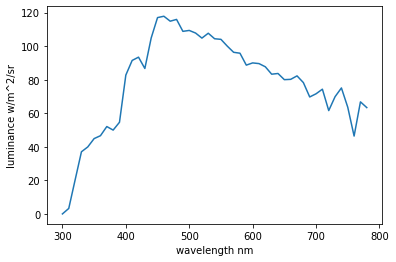

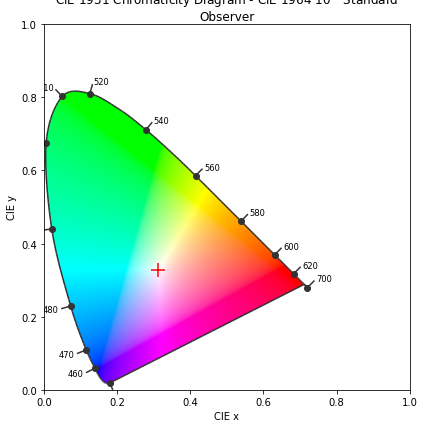

CRI = 99.99988846483116
Peak at = 460.0
Peak value = 117.812


In [18]:
target_wide_emission_SD = colour.SDS_ILLUMINANTS['D65']
target_wide_emission_values = colour.SDS_ILLUMINANTS['D65'].values
target_wide_emission_wavelengths = colour.SDS_ILLUMINANTS['D65'].wavelengths
target_wide_emission_tristim_xy = colour.XYZ_to_xy(
    colour.sd_to_XYZ(colour.SDS_ILLUMINANTS['D65']))
target_wide_emission_tristim_UCS = colour.xy_to_UCS_uv(
    target_wide_emission_tristim_xy)

plt.figure()
plt.plot(target_wide_emission_wavelengths, target_wide_emission_values)
plt.ylabel("luminance w/m^2/sr")
plt.xlabel("wavelength nm")

colour.plotting.plot_chromaticity_diagram_CIE1931(
    standalone=False, cmfs='CIE 1964 10 Degree Standard Observer')
plt.scatter(*target_wide_emission_tristim_xy, s=200, color="red", marker="+")
plt.show()

print(f"CRI = {colour.colour_rendering_index(colour.SDS_ILLUMINANTS['D65'])}")
print(
    f"Peak at = {target_wide_emission_wavelengths[np.argmax(target_wide_emission_values)]}")
print(f"Peak value = {np.max(target_wide_emission_values)}")

 # 2 - Single Wide emission match

 Create a single peak emission that has the same perceived colour as the target spectrum.
 Find the required lambda by minimising the cie-xy difference between target and the candidate spectrum.

Optimization terminated successfully.
         Current function value: 0.005353
         Iterations: 36
         Function evaluations: 76
CRI = 59.60788162473928
Peak at = 510.0
Peak value = 117.812
Delta E_00 = 42.947413287973475


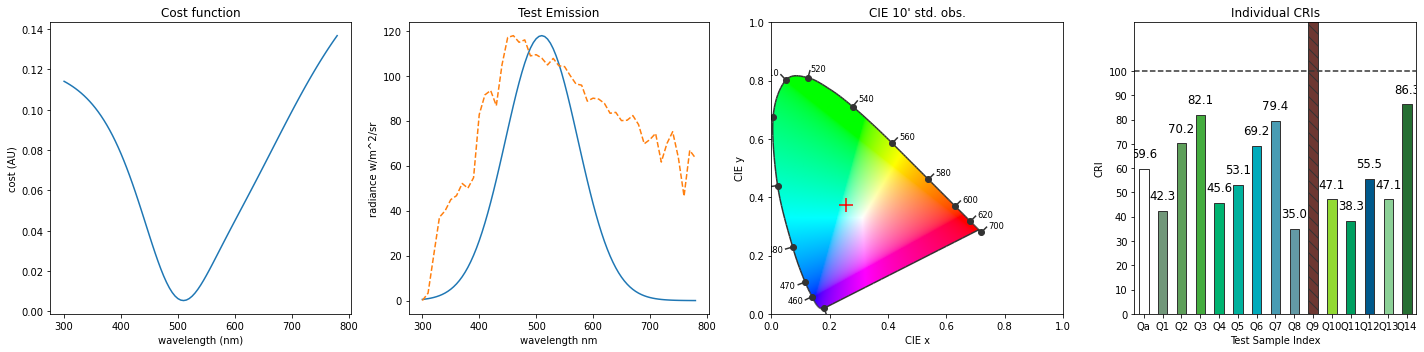

In [19]:
meanLambda_0 = 400 #initial value for the peak wavelength
fwhm_wide = 150 # wide emission FWHM
var = int(fwhm_wide)/(2*np.sqrt(2*np.log(2))) #variance of the peak spectral shape (assuming gaussian shape)
peakValue = np.max(target_wide_emission_values) #Peak luminance of the target spectrum

def wideEmissionCostFn(meanLambda):

    single_wideEmission = norm.pdf(
        target_wide_emission_wavelengths, loc=meanLambda, scale=var)
    single_wideEmission = peakValue * \
        single_wideEmission/np.max(single_wideEmission)

    single_wideEmission_sd = colour.SpectralDistribution(
        single_wideEmission, target_wide_emission_wavelengths)
    single_wideEmission_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(single_wideEmission_sd))

    return np.sum(np.square(target_wide_emission_tristim_xy - single_wideEmission_tristim_xy))


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.plot(target_wide_emission_wavelengths, [
         wideEmissionCostFn(x) for x in target_wide_emission_wavelengths])
ax1.set_title("Cost function")
ax1.set_ylabel("cost (AU)")
ax1.set_xlabel("wavelength (nm)")


res = optimize.minimize(wideEmissionCostFn, meanLambda_0, method='nelder-mead',
                        options={'xatol': 1e-8, 'disp': True})
meanLambda = res.x[0]

single_wideEmission = norm.pdf(
    target_wide_emission_wavelengths, loc=meanLambda, scale=var)
single_wideEmission = peakValue * \
    single_wideEmission/np.max(single_wideEmission)

single_wideEmission_sd = colour.SpectralDistribution(
    single_wideEmission, target_wide_emission_wavelengths)
single_wideEmission_tristim_xy = colour.XYZ_to_xy(
    colour.sd_to_XYZ(single_wideEmission_sd))

ax2.set_title("Test Emission")
ax2.plot(target_wide_emission_wavelengths, single_wideEmission)
ax2.plot(target_wide_emission_wavelengths, target_wide_emission_values, '--')
ax2.set_ylabel("radiance w/m^2/sr")
ax2.set_xlabel("wavelength nm")

colour.plotting.plot_chromaticity_diagram_CIE1931(
    standalone=False, cmfs='CIE 1964 10 Degree Standard Observer', axes=ax3)
ax3.scatter(*single_wideEmission_tristim_xy, s=200, color="red", marker="+")
ax3.set_title("CIE 10' std. obs.")
colour.plotting.plot_single_sd_colour_rendering_index_bars(
    single_wideEmission_sd, standalone=False, axes=ax4)
ax4.set_title("Individual CRIs")
ax4.set_ylabel("CRI")
ax4.set_xlabel("Test Sample Index")
fig.show()

if touchDisk:
    fig.savefig(os.path.join(figPath, "wideE"))

print(f"CRI = {colour.colour_rendering_index(single_wideEmission_sd)}")
print(
    f"Peak at = {target_wide_emission_wavelengths[np.argmax(single_wideEmission)]}")
print(f"Peak value = {np.max(single_wideEmission)}")
print(f"Delta E_00 = {colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(single_wideEmission_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD)))}")


 ---
 ## 3 - Uniformly distributed primaries (Without Optimisation) (only as an example)

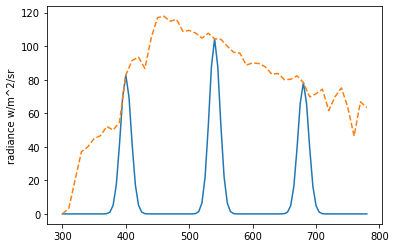

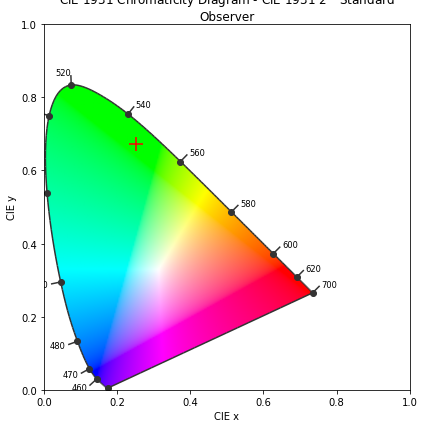

In [20]:
# Config
n_primaries = 3
fwhm_narrow = 20

var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))

meanLambdas_0 = np.linspace(np.min(target_wide_emission_wavelengths) +
                            100, np.max(target_wide_emission_wavelengths)-100, n_primaries)

test_spectrum = np.zeros_like(target_wide_emission_wavelengths)
for p_idx in range(n_primaries):
    primary_spectrum = norm.pdf(
        target_wide_emission_wavelengths, loc=meanLambdas_0[p_idx], scale=var)
    primary_spectrum = target_wide_emission_SD[meanLambdas_0[p_idx]
                                               ] * primary_spectrum/np.max(primary_spectrum)
    test_spectrum += primary_spectrum

test_spectrum_sd = colour.SpectralDistribution(
    test_spectrum, target_wide_emission_wavelengths)

test_spectrum_tristim_xy = colour.XYZ_to_xy(colour.sd_to_XYZ(test_spectrum_sd))

plt.plot(target_wide_emission_wavelengths, test_spectrum)
plt.plot(target_wide_emission_wavelengths, target_wide_emission_values, '--')

plt.ylabel("radiance w/m^2/sr")

colour.plotting.plot_chromaticity_diagram_CIE1931(
    standalone=False, cmfs='CIE 1931 2 Degree Standard Observer')
plt.scatter(*test_spectrum_tristim_xy, s=200, color="red", marker="+")
plt.show()

 ## 4 - Uniform Prior - tune wthout constraints

 Start with uniformly primaries, then adjust lambda till the xy matches the target spectrum. This is minimising the difference between xy values

nEmissionCostFn_criAndxyDiff_2
Optimising for 3 primaries.
Initial Peak Wavelengths = [ 330.  516.  702.]
Optimization terminated successfully.
         Current function value: 0.177493
         Iterations: 704
         Function evaluations: 1357
[ 461.53851519  549.91924153  613.18070394]
Optimised Peak Wavelengths = [ 461.53851519  549.91924153  613.18070394]
Optimised Radiances = [117.3578303151985, 104.04889115323228, 88.994639022578085]
cri = 82.36013790850308. (min = 26.54579961254116. max =98.0458657863367)
Optimising for 4 primaries.
Initial Peak Wavelengths = [ 330.  454.  578.  702.]
Optimization terminated successfully.
         Current function value: 0.158250
         Iterations: 407
         Function evaluations: 749
[ 377.10483117  464.92589796  537.5         608.55279333]
Optimised Peak Wavelengths = [ 377.10483117  464.92589796  537.5         608.55279333]
Optimised Radiances = [50.587422884137347, 116.35787492109986, 105.226, 89.65800131156287]
cri = 84.17888960595101

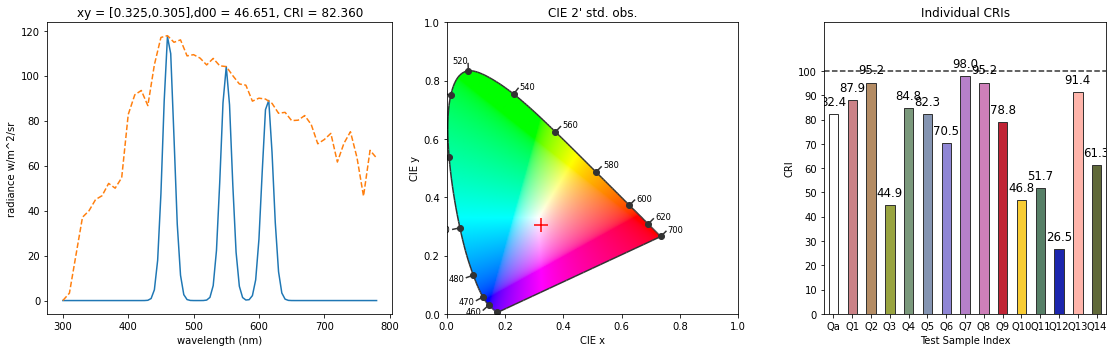

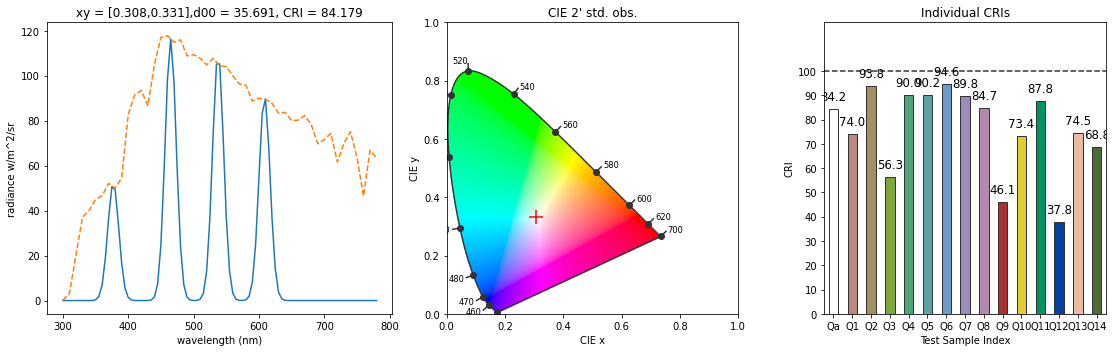

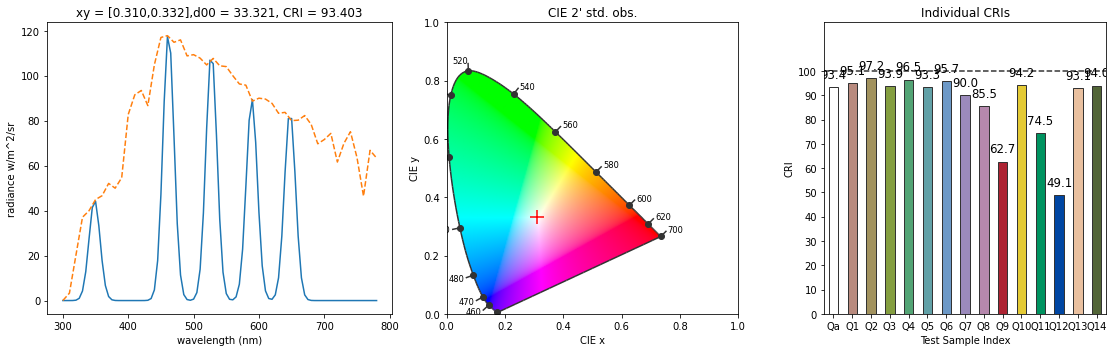

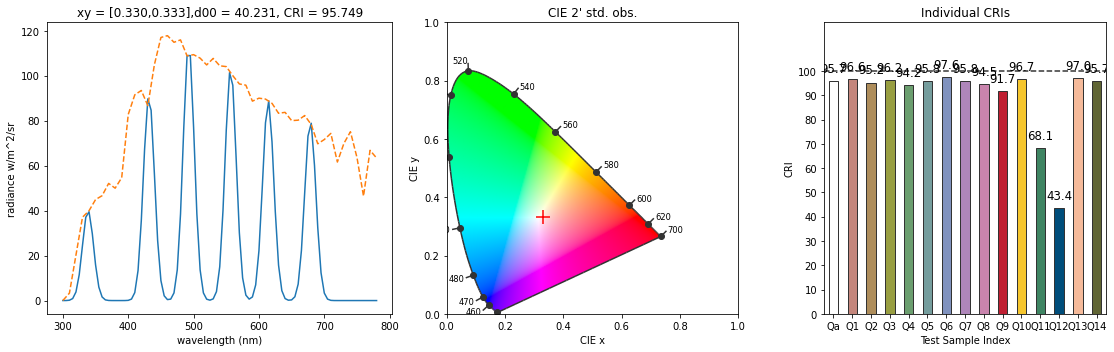

In [21]:
n_primaries = 6
fwhm_narrow = 20

var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))
optimiseSpect = True
# optimiseSpect_by = "criAndxyDiff_sequential"
print(optimiseSpect_by)
decomposition_list = []


if fullOptHistory:
    allVecIterTrace = []

for n_primaries in range(3, n_primaries+1):
    print(f"Optimising for {n_primaries} primaries.")
    meanLambdas_0 = np.linspace(np.min(target_wide_emission_wavelengths)
                                * 1.1, np.max(target_wide_emission_wavelengths)*0.9, n_primaries)
    print("Initial Peak Wavelengths =", meanLambdas_0)

    if optimiseSpect:
        meanLambdas = optimiseSpectrum(meanLambdas_0, optimiseSpect_by)

    else:
        meanLambdas = meanLambdas_0

    test_spectrum_sd = generateMultiPrimarySpectrum(meanLambdas)
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))

    fig = plotSpectChrCRI(test_spectrum_sd)
    fig.show()

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    print(f"Optimised Peak Wavelengths = {meanLambdas}")
    print(
        f"Optimised Radiances = {[target_wide_emission_SD[lam] for lam in meanLambdas]}")
    print(f"cri = {colour.colour_rendering_index(test_spectrum_sd)}. (min = {np.min(Q_as)}. max ={np.max(Q_as)})")

    if touchDisk:
        fig.savefig(os.path.join(
            figPath, f"narrowE_unif_p={n_primaries}_{optimiseSpect_by}"))

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    decomposition_list.append({
        'spectRadiance': test_spectrum_sd.values,
        'n_primaries': n_primaries,
        'cie_xy': test_spectrum_tristim_xy,
        'E_00': colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'E_94': colour.difference.delta_E_CIE1994(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'Q_as': Q_as,
        'Q_as_max': np.max(Q_as),
        'Q_as_min': np.min(Q_as),
        'cri': colour.colour_rendering_index(test_spectrum_sd),
        'error': np.sum(np.abs(target_wide_emission_SD.values-test_spectrum_sd.values)),
    })

decomposition = pd.DataFrame(decomposition_list)


In [22]:
sz = 7
alp = 0.8

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_00")
p.scatter(x='n_primaries', y='E_00', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_E00.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_94")
p.scatter(x='n_primaries', y='E_94', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_E94.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="CRI")
p.add_layout(Whisker(source=ColumnDataSource(decomposition),
             base="n_primaries", upper="Q_as_max", lower="Q_as_min"))
p.scatter(x='n_primaries', y='cri', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=colour.colour_rendering_index(
    target_wide_emission_SD), line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_CRI.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Spectral MAE")
p.add_layout(Whisker(source=ColumnDataSource(
    decomposition), base="n_primaries"))
p.scatter(x='n_primaries', y='error', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
# p.line(x=decomposition['n_primaries'], y= colour.colour_rendering_index(target_wide_emission_SD),line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_MAE.png"))

decomposition


,spectRadiance,n_primaries,cie_xy,E_00,E_94,Q_as,Q_as_max,Q_as_min,cri,error
0,"[3.34031691172e-77, 2.04797205461e-72, 8.87861...",3,"[0.324587027729, 0.304753937901]",46.651054,810.333572,"[87.9098999, 95.2356389036, 44.9413050808, 84....",98.045866,26.545800,82.360138,6268.075122
1,"[6.61727712398e-17, 1.16548992357e-14, 1.45151...",4,"[0.308116338767, 0.331147267696]",35.691257,791.995946,"[74.0279743502, 93.7771017574, 56.3240333111, ...",94.607249,37.805167,84.178890,6035.133304
2,"[3.88915390553e-06, 9.39000641564e-05, 0.00160...",5,"[0.310224168447, 0.332009062715]",33.320747,724.490377,"[95.1034405444, 97.2401523313, 93.8657506798, ...",97.240152,49.076467,93.402660,5696.402955
3,"[0.00143609979065, 0.017334341244, 0.147950033...",6,"[0.329837606069, 0.332990178571]",40.231183,735.588579,"[96.6256382049, 95.2426319842, 96.2113541534, ...",97.592264,43.413939,95.749029,5408.660431


 ## 5 - CMF range Prior - tune wthout constraints

 Start with the primaries spread between the LMS cone fundamentals and then adjust lambda till the xy matches the target spectrum. This is minimising the difference between xy values

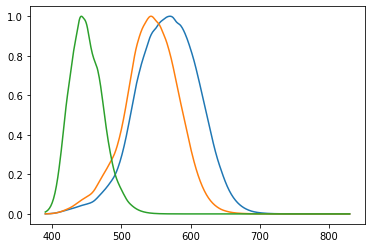

In [23]:
chosen_cmf = colour.MSDS_CMFS['Stockman & Sharpe 2 Degree Cone Fundamentals']
# chosen_cmf = colour.colorimetry.LMS_ConeFundamentals
plt.plot(chosen_cmf.wavelengths,chosen_cmf.values)
lambdaPeaks = [chosen_cmf.wavelengths[np.argmax(
    x)] for x in chosen_cmf.values.transpose()]


nEmissionCostFn_criAndxyDiff_2
Optimising for 3 primaries.
Initial Peak Wavelengths = [ 419.9   523.45  627.  ]
Optimization terminated successfully.
         Current function value: 0.152715
         Iterations: 249
         Function evaluations: 460
[ 463.07636747  542.5         610.46091066]
Optimised Peak Wavelengths = [ 463.07636747  542.5         610.46091066]
Optimised Radiances = [116.90385632186651, 104.31500000003422, 89.511508537642754]
cri = 84.74410224340993. (min = 28.243202282813883. max =97.89802019968128)
Optimising for 4 primaries.
Initial Peak Wavelengths = [ 419.9         488.93333333  557.96666667  627.        ]
Optimization terminated successfully.
         Current function value: 0.028386
         Iterations: 341
         Function evaluations: 629
[ 449.60530148  502.16105667  558.55179049  616.27318307]
Optimised Peak Wavelengths = [ 449.60530148  502.16105667  558.55179049  616.27318307]
Optimised Radiances = [116.52867811587973, 109.01860400516355, 100.5859455

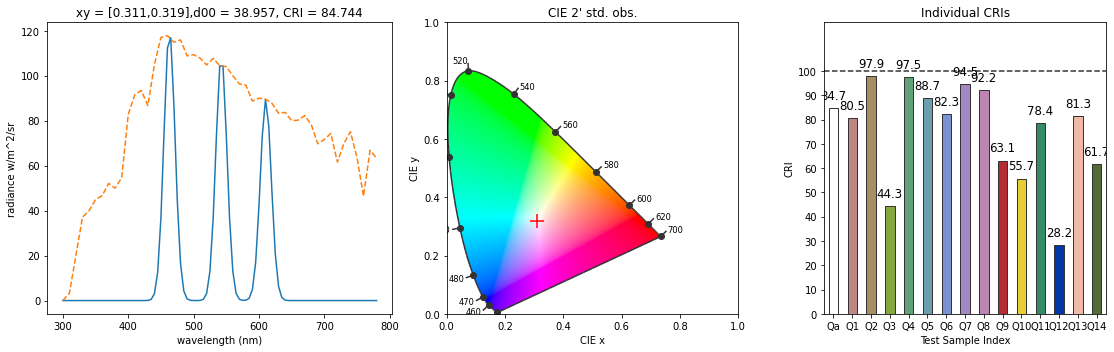

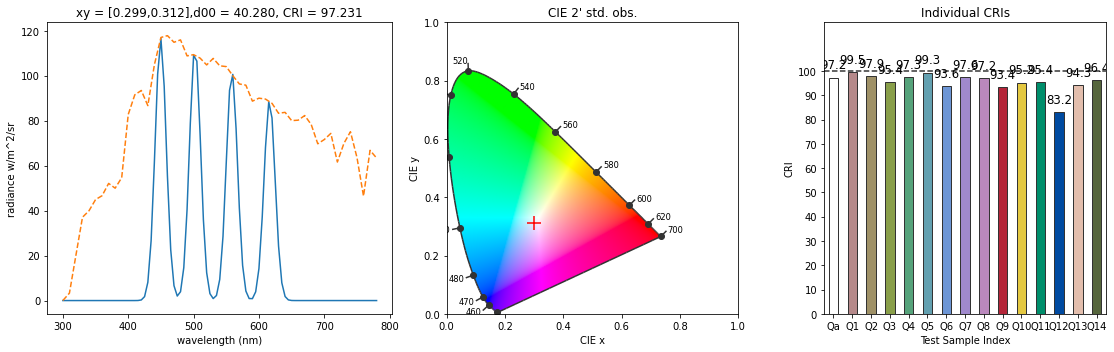

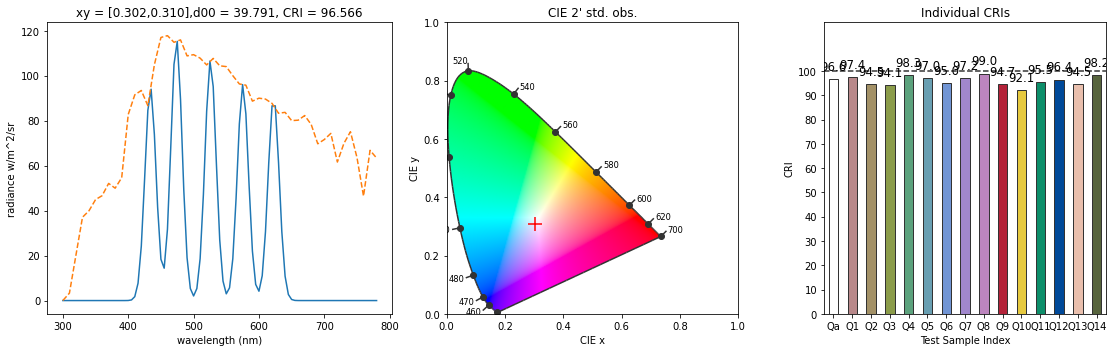

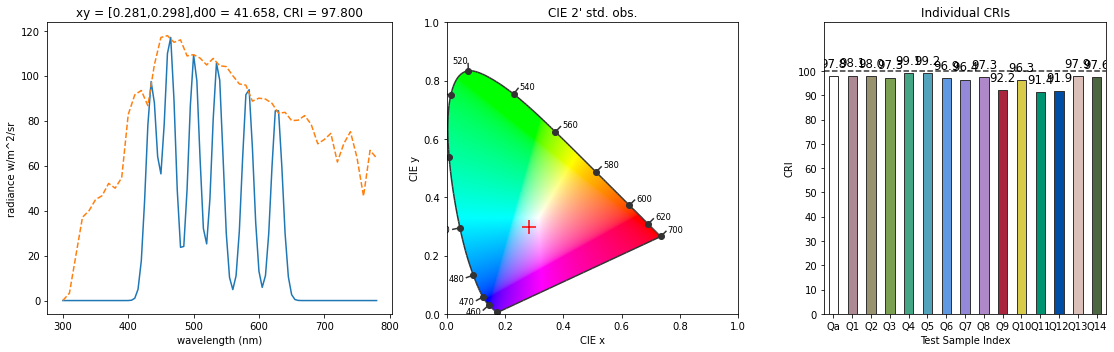

In [24]:
n_primaries = 6
fwhm_narrow = 20

var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))
optimiseSpect = True
# optimiseSpect_by = "nEmissionCostFn_criAndxyDiff_2"
print(optimiseSpect_by)
decomposition_list = []

# colour.STANDARD_OBSERVERS_CMFS['cie_2_1931']
chosen_cmf = colour.MSDS_CMFS['Stockman & Sharpe 2 Degree Cone Fundamentals']
lambdaPeaks = [chosen_cmf.wavelengths[np.argmax(
    x)] for x in chosen_cmf.values.transpose()]

if fullOptHistory:
    allVecIterTrace = []

for n_primaries in range(3, n_primaries+1):
    print(f"Optimising for {n_primaries} primaries.")

    meanLambdas_0 = np.linspace(
        np.min(lambdaPeaks)*0.95, np.max(lambdaPeaks)*1.1, n_primaries)
    print("Initial Peak Wavelengths =",meanLambdas_0)
    if optimiseSpect:
        meanLambdas = optimiseSpectrum(meanLambdas_0, optimiseSpect_by)

    else:
        meanLambdas = meanLambdas_0

    test_spectrum_sd = generateMultiPrimarySpectrum(meanLambdas)
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))

    fig = plotSpectChrCRI(test_spectrum_sd)
    fig.show()

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    print(f"Optimised Peak Wavelengths = {meanLambdas}")
    print(
        f"Optimised Radiances = {[target_wide_emission_SD[lam] for lam in meanLambdas]}")
    print(f"cri = {colour.colour_rendering_index(test_spectrum_sd)}. (min = {np.min(Q_as)}. max ={np.max(Q_as)})")

    if touchDisk:
        fig.savefig(os.path.join(
            figPath, f"narrowE_unif_p={n_primaries}_{optimiseSpect_by}"))

    decomposition_list.append({
        'spectRadiance': test_spectrum_sd.values,
        'n_primaries': n_primaries,
        'cie_xy': test_spectrum_tristim_xy,
        'E_00': colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'E_94': colour.difference.delta_E_CIE1994(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'Q_as': Q_as,
        'Q_as_max': np.max(Q_as),
        'Q_as_min': np.min(Q_as),
        'cri': colour.colour_rendering_index(test_spectrum_sd),
        'error': np.sum(np.abs(target_wide_emission_SD.values-test_spectrum_sd.values)),
    })

decomposition = pd.DataFrame(decomposition_list)


In [25]:
sz = 7
alp = 0.8

p = figure(plot_width=300, plot_height=300,
           x_axis_label="number of primaries", y_axis_label="Delta E_00")
p.scatter(x='n_primaries', y='E_00', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_E00.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_94")
p.scatter(x='n_primaries', y='E_94', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_E94.png"))

p = figure(plot_width=300, plot_height=300,
           x_axis_label="number of primaries", y_axis_label="CRI", y_range=[50, 102])
p.add_layout(Whisker(source=ColumnDataSource(decomposition),
             base="n_primaries", upper="Q_as_max", lower="Q_as_min"))
p.scatter(x='n_primaries', y='cri', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=colour.colour_rendering_index(
    target_wide_emission_SD), line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_CRI.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Spectral MAE")
p.add_layout(Whisker(source=ColumnDataSource(
    decomposition), base="n_primaries"))
p.scatter(x='n_primaries', y='error', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
# p.line(x=decomposition['n_primaries'], y= colour.colour_rendering_index(target_wide_emission_SD),line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None

if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_unif_{optimiseSpect_by}_MAE.png"))

decomposition


,spectRadiance,n_primaries,cie_xy,E_00,E_94,Q_as,Q_as_max,Q_as_min,cri,error
0,"[1.05522997374e-78, 7.19742982579e-74, 3.47130...",3,"[0.310929261285, 0.318968495494]",38.956893,793.474223,"[80.4941268093, 97.8980201997, 44.3103051487, ...",97.898020,28.243202,84.744102,6251.214266
1,"[4.91057194024e-66, 1.31656681594e-61, 2.49596...",4,"[0.299061676538, 0.312269948898]",40.279878,696.135355,"[99.5282917201, 97.8676926542, 95.4157900678, ...",99.528292,83.175137,97.231376,5815.887341
2,"[8.11436332374e-53, 7.38435848467e-49, 4.75177...",5,"[0.302074981324, 0.309781363393]",39.790913,598.880868,"[97.4493795124, 94.4798123247, 94.1132417493, ...",98.953701,92.106539,96.566044,5460.274597
3,"[3.77983039344e-54, 3.85800646168e-50, 2.78444...",6,"[0.281100635851, 0.298376440248]",41.657604,498.767826,"[98.0725588623, 97.9500987323, 97.2952896456, ...",99.245017,91.383895,97.799990,4986.702160


 ## 6 - Constrained optimisation to the CMF Range


Optimising for 3 primaries.
Initial Peak Wavelengths = [ 356.  538.  720.]
         Current function value: 0.265129
         Iterations: 31
         Function evaluations: 768
         Gradient evaluations: 190
[ 472.28396285  542.49999999  624.02894757]
Optimised Peak Wavelengths = [ 472.28396285  542.49999999  624.02894757]
Optimised Radiances = [115.10355685443146, 104.31500000021204, 85.921853543884069]
cri = 73.61790346865533. (min = -34.75710367188026. max =89.40370901705678)
Optimising for 4 primaries.
Initial Peak Wavelengths = [ 356.          477.33333333  598.66666667  720.        ]
         Current function value: 0.886708
         Iterations: 6
         Function evaluations: 328
         Gradient evaluations: 64
[ 355.99985794  481.89318512  574.58678086  719.96273   ]
Optimised Peak Wavelengths = [ 355.99985794  481.89318512  574.58678086  719.96273   ]
Optimised Radiances = [45.947635471745855, 114.57656673925949, 96.08367002936599, 61.65150062027201]
cri = 11.54900120095

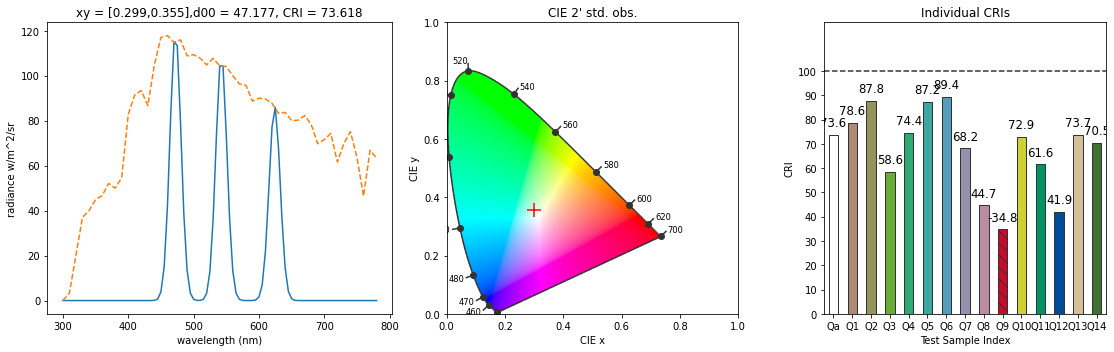

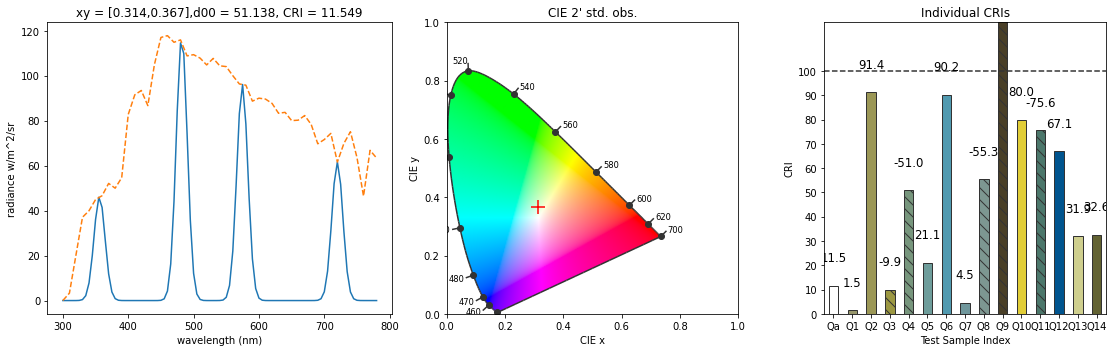

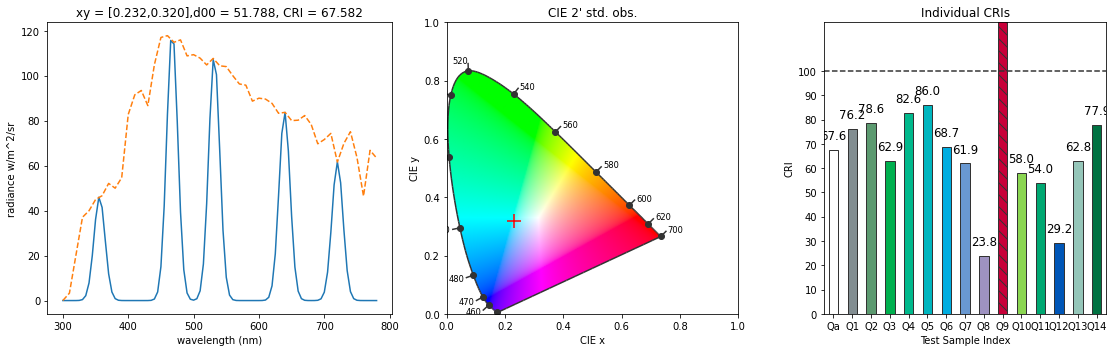

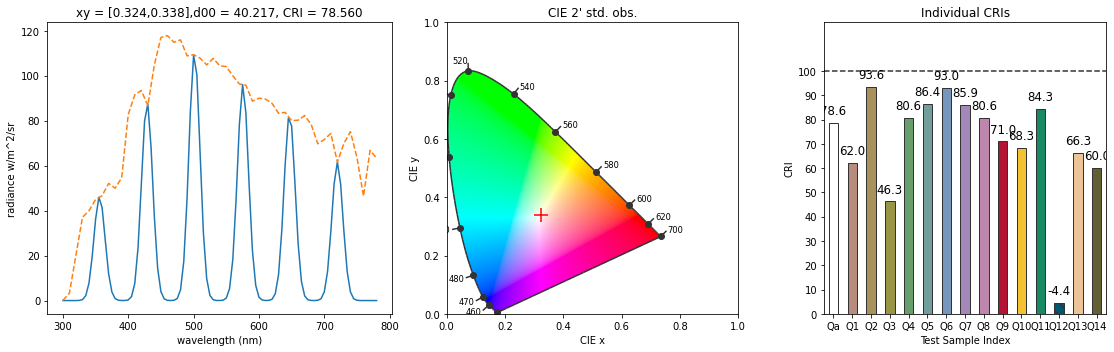

In [26]:
n_primaries = 6
fwhm_narrow = 30

var = int(fwhm_narrow)/(2*np.sqrt(2*np.log(2)))
optimiseSpect = True
# optimiseSpect_by = 'criAndxyDiff_sequential'
decomposition_list = []

chosen_cmf = colour.colorimetry.MSDS_CMFS_STANDARD_OBSERVER['cie_2_1931']
chosen_cmf.align(colour.quality.SDS_TCS['TCS01'].shape)
lambdaPeaks = [chosen_cmf.wavelengths[np.argmax(
    x)] for x in chosen_cmf.values.transpose()]


if fullOptHistory:
    allVecIterTrace = []

for n_primaries in range(3, n_primaries+1):
    print(f"Optimising for {n_primaries} primaries.")
    meanLambdas_0 = np.linspace(
        np.min(lambdaPeaks)*0.8, np.max(lambdaPeaks)*1.2, n_primaries)
    print("Initial Peak Wavelengths =", meanLambdas_0)

    if optimiseSpect:
        meanLambdas = optimiseSpectrum(meanLambdas_0, optimiseSpect_by, optimiser='BFGS', bounds=(
            [(np.min(lambdaPeaks)*0.9, np.min(lambdaPeaks)*1.3)]*n_primaries))

    else:
        meanLambdas = meanLambdas_0

    test_spectrum_sd = generateMultiPrimarySpectrum(meanLambdas)
    test_spectrum_tristim_xy = colour.XYZ_to_xy(
        colour.sd_to_XYZ(test_spectrum_sd))

    fig = plotSpectChrCRI(test_spectrum_sd)
    fig.show()

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    print(f"Optimised Peak Wavelengths = {meanLambdas}")
    print(
        f"Optimised Radiances = {[target_wide_emission_SD[lam] for lam in meanLambdas]}")
    print(f"cri = {colour.colour_rendering_index(test_spectrum_sd)}. (min = {np.min(Q_as)}. max ={np.max(Q_as)})")

    if touchDisk:
        fig.savefig(os.path.join(
            figPath, f"narrowE_cmfPrior_p={n_primaries}_{fwhm_narrow}nm_{optimiseSpect_by}"))

    Q_as = [x.Q_a for _, x in colour.colour_rendering_index(
        test_spectrum_sd, additional_data=True).Q_as.items()]

    decomposition_list.append({
        'spectRadiance': test_spectrum_sd.values,
        'n_primaries': n_primaries,
        'cie_xy': test_spectrum_tristim_xy,
        'E_00': colour.difference.delta_E_CIE2000(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'E_94': colour.difference.delta_E_CIE1994(colour.XYZ_to_Lab(colour.sd_to_XYZ(test_spectrum_sd)), colour.XYZ_to_Lab(colour.sd_to_XYZ(target_wide_emission_SD))),
        'Q_as': Q_as,
        'Q_as_max': np.max(Q_as),
        'Q_as_min': np.min(Q_as),
        'cri': colour.colour_rendering_index(test_spectrum_sd),
        'error': np.sum(np.abs(target_wide_emission_SD.values-test_spectrum_sd.values)),
    })

decomposition = pd.DataFrame(decomposition_list)


In [27]:
sz = 7
alp = 0.8

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_00")
p.scatter(x='n_primaries', y='E_00', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None
if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_lmsPrior_{optimiseSpect_by}_E00.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Delta E_94")
p.scatter(x='n_primaries', y='E_94', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=0, line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None
if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_lmsPrior_{optimiseSpect_by}_E94.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="CRI")
p.add_layout(Whisker(source=ColumnDataSource(decomposition),
             base="n_primaries", upper="Q_as_max", lower="Q_as_min"))
p.scatter(x='n_primaries', y='cri', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
p.line(x=decomposition['n_primaries'], y=colour.colour_rendering_index(
    target_wide_emission_SD), line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None
if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_lmsPrior_{optimiseSpect_by}_CRI.png"))

p = figure(plot_width=500, plot_height=200,
           x_axis_label="number of primaries", y_axis_label="Spectral MAE")
p.add_layout(Whisker(source=ColumnDataSource(
    decomposition), base="n_primaries"))
p.scatter(x='n_primaries', y='error', source=ColumnDataSource(
    decomposition), alpha=alp, size=sz)
# p.line(x=decomposition['n_primaries'], y= colour.colour_rendering_index(target_wide_emission_SD),line_alpha=0.5)
show(p)
p.toolbar.logo = None
p.toolbar_location = None
if touchDisk:
    export_png(p, filename=os.path.join(
        figPath, f"narrowE_lmsPrior_{optimiseSpect_by}_MAE.png"))

decomposition

,spectRadiance,n_primaries,cie_xy,E_00,E_94,Q_as,Q_as_max,Q_as_min,cri,error
0,"[5.31838151497e-88, 6.86730044586e-83, 6.27014...",3,"[0.299350586463, 0.355344470806]",47.177112,836.009747,"[78.6494703081, 87.827236332, 58.5598686125, 7...",89.403709,-34.757104,73.617903,6267.419615
1,"[1.67888072836e-08, 6.84740545167e-07, 1.97477...",4,"[0.314179242568, 0.367256419371]",51.138177,1002.102718,"[1.48389716416, 91.3521926067, -9.91347125751,...",91.352193,-350.121455,11.549001,6237.365760
2,"[1.67565832607e-08, 6.83546237493e-07, 1.97167...",5,"[0.232098909545, 0.320016248105]",51.787954,938.789620,"[76.1930637589, 78.572644473, 62.9288203014, 8...",86.011652,-127.112422,67.581550,5813.902294
3,"[1.67867118127e-08, 6.84662887835e-07, 1.97457...",6,"[0.324368295921, 0.33833037164]",40.216606,861.125530,"[62.0212298666, 93.5924404848, 46.2846062184, ...",93.592440,-4.364109,78.559732,5538.592439
